In [1]:
%matplotlib inline
import copy

import numpy as np
import torch
import torch.nn.utils.prune as prune
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
cmap = plt.get_cmap("viridis")
from tqdm import tqdm

import config
from graph_models import FullGraphModel
from complete_training_data_processing import CompleteModelsDataProcessor
from utils import (
    clean_model_outputs, 
    get_image_paths, 
    get_iteration_number, 
    initialize_results_df, 
    select_random_images, 
    update_results_df, 
    update_running_loss, 
    plot_results
)

device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
dtype = torch.float32
batch_size = config.batch_size

In [2]:
data_processor = CompleteModelsDataProcessor(
    neurons=config.neurons,
    voronoi_criteria=config.voronoi_criteria,
    random_synapses=config.random_synapses,
    log_transform_weights=config.log_transform_weights,
)

model = FullGraphModel(
    input_shape=data_processor.number_of_synapses,
    num_connectome_passes=config.NUM_CONNECTOME_PASSES,
    decision_making_vector=data_processor.decision_making_vector,
    batch_size=config.batch_size,
    dtype=config.dtype,
    edge_weights=data_processor.synaptic_matrix.data,
    device=config.DEVICE,
    num_classes=len(config.CLASSES),
).to(device)
criterion = CrossEntropyLoss()

In [3]:
def correct_test_results(test_results):
    # There was a bug in how we get the classes, and the 0-1 labels can be flipped
    # This function corrects the labels if the accuracy is below 0.5
    flipped = False
    if test_results["Is correct"].sum() / len(test_results) < 0.5:
        test_results["Is correct"] = np.abs(test_results["Is correct"] - 1)
        flipped = True

    return test_results, flipped

# test
def test(model):
    testing_images = get_image_paths(
        config.TESTING_DATA_DIR, config.small, config.small_length
    )
    already_selected_testing = []
    total_correct, total, running_loss = 0, 0, 0.0
    test_results = initialize_results_df()

    iterations = get_iteration_number(len(testing_images), batch_size)
    for _ in tqdm(range(iterations)):
        batch_files, already_selected_testing = select_random_images(
            testing_images, batch_size, already_selected_testing
        )
        images, labels = data_processor.get_data_from_paths(batch_files)
        inputs, labels = data_processor.process_batch(images, labels)
        inputs = inputs.to(config.DEVICE)

        out = model(inputs)
        loss = criterion(out, labels)

        # Calculate run parameters
        outputs, predictions, labels_cpu, correct = clean_model_outputs(out, labels)
        test_results = update_results_df(
            test_results, batch_files, outputs, predictions, labels_cpu, correct
        )
        running_loss += update_running_loss(loss, inputs)
        total += batch_size
        total_correct += correct.sum()

    test_results, flipped = correct_test_results(test_results)
    final_plots = plot_results(test_results, plot_types=config.plot_types)

    print(
        f"Finished testing with loss {running_loss / total} and "
        f"accuracy {total_correct / total}."
    )
    return test_results, final_plots, total_correct / total, flipped

In [4]:
checkpoint = torch.load(
    "models/n_all_v_R7_r_False_lr_0.001_p_4_2024-05-23 18:58.pth",
    map_location=device_type,
)
model.load_state_dict(checkpoint["model"])
torch.set_grad_enabled(False)
model.eval()
model_orig = copy.deepcopy(model)


In [6]:
results = {}
for ix, p in enumerate(np.linspace(0, 1, 11)):
    model = copy.deepcopy(model_orig)
    prune.random_unstructured(
        model.connectome, name="edge_weight_multiplier", amount=p
    )
    test_results, final_plots, accuracy, flipped = test(model)
    results[f"prune_{ix}"] = {
        "prune_frac": p,
        "test_results": test_results,
        "final_plots": final_plots,
        "accuracy": accuracy,
        "flipped": flipped,
    }

100%|██████████| 212/212 [13:47<00:00,  3.90s/it]


Finished testing with loss 233416.30759385342 and accuracy 0.2212558962264151.


100%|██████████| 212/212 [13:19<00:00,  3.77s/it]


Finished testing with loss 231562.8048477454 and accuracy 0.24027122641509435.


100%|██████████| 212/212 [12:21<00:00,  3.50s/it]


Finished testing with loss 226160.74836994737 and accuracy 0.27476415094339623.


100%|██████████| 212/212 [12:20<00:00,  3.49s/it]


Finished testing with loss 216984.9025697798 and accuracy 0.3071933962264151.


100%|██████████| 212/212 [12:25<00:00,  3.51s/it]


Finished testing with loss 219334.1154865999 and accuracy 0.3004127358490566.


100%|██████████| 212/212 [12:23<00:00,  3.51s/it]


Finished testing with loss 214542.8628590686 and accuracy 0.3167747641509434.


100%|██████████| 212/212 [12:25<00:00,  3.52s/it]


Finished testing with loss 196677.7914663885 and accuracy 0.3590801886792453.


100%|██████████| 212/212 [12:25<00:00,  3.52s/it]


Finished testing with loss 194048.8772412665 and accuracy 0.3758844339622642.


100%|██████████| 212/212 [12:26<00:00,  3.52s/it]


Finished testing with loss 157600.9953765664 and accuracy 0.45150353773584906.


100%|██████████| 212/212 [12:28<00:00,  3.53s/it]


Finished testing with loss 136309.67340143785 and accuracy 0.4492924528301887.


100%|██████████| 212/212 [12:26<00:00,  3.52s/it]


Finished testing with loss nan and accuracy 0.5001474056603774.


In [12]:
import pandas as pd
pa = pd.DataFrame({"prune_frac": [r["prune_frac"] for r in results.values()], "accuracy": [1 - r["accuracy"] for r in results.values()]})

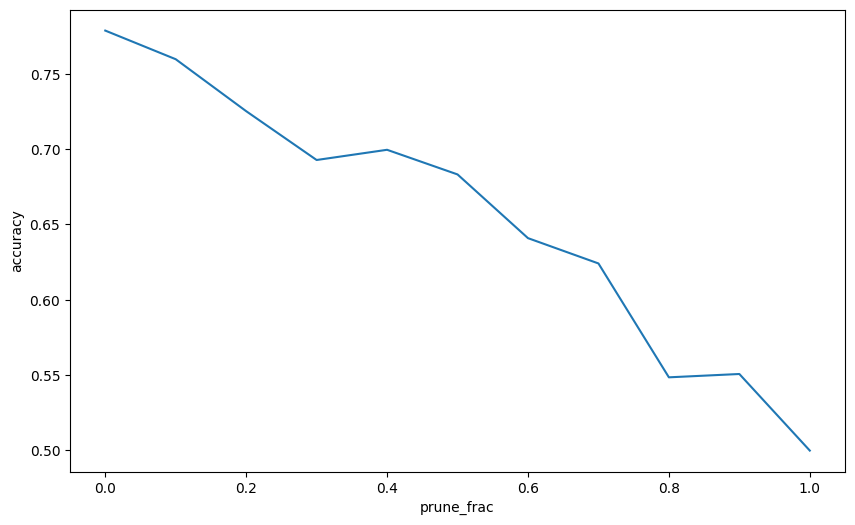

In [18]:
%matplotlib inline
import seaborn as sns

fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=pa, x="prune_frac", y="accuracy")
plt.show()